In [1]:
%matplotlib widget

In [2]:
from glob import glob
import numpy as np
import pandas as pd
import flammkuchen as fl
from split_dataset import SplitDataset
from bouter import Experiment
from motions.utilities import stim_vel_dir_dataframe, quantize_directions
from scipy.interpolate import interp1d 
from scipy.signal import convolve2d
import colorspacious
import matplotlib.pyplot as plt

from fimpylab.core.lightsheet_experiment import LightsheetExperiment

import json
from pathlib import Path

In [3]:
# make sensory regressors. requires old bouter stimulus_param_log.
def make_sensory_regressors(exp, n_dirs=8, upsampling=5, sampling=1/3):
    stim = stim_vel_dir_dataframe(exp)
    bin_centres, dir_bins = quantize_directions(stim.theta)
    ind_regs = np.zeros((n_dirs, len(stim)))
    for i_dir in range(n_dirs):
        ind_regs[i_dir, :] = (np.abs(dir_bins - i_dir) < 0.1) & (stim.vel > 0.1)  

    dt_upsampled = sampling / upsampling
    t_imaging_up = np.arange(0, stim.t.values[-1], dt_upsampled)
    reg_up = interp1d(stim.t.values, ind_regs, axis=1, fill_value="extrapolate")(
        t_imaging_up
    )
    
    # 6s kernel
    u_steps = t_imaging_up.shape[0]
    u_time = np.arange(u_steps) * dt_upsampled
    decay = np.exp(-u_time / (1.5 / np.log(2)))
    kernel = decay / np.sum(decay)
    
    convolved = convolve2d(reg_up, kernel[None, :])[:, 0:u_steps]
    reg_sensory = convolved[:, ::upsampling]

    return pd.DataFrame(reg_sensory.T, columns=[f"motion_{i}" for i in range(n_dirs)])

In [4]:
# calculate directional tuning from zscored traces for each roi
def get_tuning_map(traces, sens_regs, n_dirs=8):

    n_t = sens_regs.shape[0]
    reg = sens_regs.values.T @ traces[:n_t, :]
#     print(np.shape(reg))
    #reg = reg.reshape(reg.shape[0], traces.shape[-1], traces.shape[-1])
    
    # tuning vector
    bin_centers, bins = quantize_directions([0], n_dirs)
    vectors = np.stack([np.cos(bin_centers), np.sin(bin_centers)], 0)
#     print(np.shape(vectors))
    reg_vectors = vectors @ reg
#     print(np.shape(reg_vectors))
    
    angle = np.arctan2(reg_vectors[1], reg_vectors[0])
    amp = np.sqrt(np.sum(reg_vectors ** 2, 0))

    return amp, angle

In [5]:
# make a color map
def JCh_to_RGB255(x):
    output = np.clip(colorspacious.cspace_convert(x, "JCh", "sRGB1"), 0, 1)
    return (output * 255).astype(np.uint8)

def color_stack(
        amp,
        angle,
        hueshift=2.5,
        amp_percentile=80,
        maxsat=50,
        lightness_min=100,
        lightness_delta=-40,
    ):
    output_lch = np.zeros((amp.shape[0], 3))
#     print(np.shape(output_lch))
    output_lch[:,0]
    maxamp = np.percentile(amp, amp_percentile)

    output_lch[:, 0] = (
            lightness_min + (np.clip(amp / maxamp, 0, 1)) * lightness_delta
    )
    output_lch[:, 1] = (np.clip(amp / maxamp, 0, 1)) * maxsat
    output_lch[:, 2] = (-angle + hueshift) * 180 / np.pi

    return JCh_to_RGB255(output_lch)

In [6]:
# master = Path(r"Z:\Hagar and Ot\E0040\v10\LS")
master = Path(r'\\portulab.synology.me\data\Hagar and Ot\E0040\v10\LS')
fish_list = list(master.glob("*_f*"))
fish_list

[WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240702_f0'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240702_f1'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240702_f2'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240702_f3'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240705_f1'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240705_f11'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240705_f12'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240705_f2'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240705_f3'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240705_f4'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240705_f5'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240705_f6'),
 WindowsPath('//portulab.s

# Load also morphed coordinates

In [7]:
morphed_coords = {}
# in_brain_idx = {}
in_brain_arr = {}

for fish in fish_list:
    print(fish)
    
    #Load morphed coords
    morphed_coords[fish.name] = fl.load(fish / 'registration' / 'to_h2b_baier_ref' / 'antspy' / 'mov_coords_transformed.h5')
    
    #I guess this is an index to keep track of ROIs inside brain? Will make it into a boolean because makes more sense
    suite2p_brain = fl.load(fish / "data_from_suite2p_cells_brain.h5")
#     in_brain_idx[fish.name] = suite2p_brain['coords_idx'] 
    
    in_brain_arr[fish.name] = np.full(morphed_coords[fish.name].shape[0], False)
    in_brain_arr[fish.name][suite2p_brain['coords_idx']] = True
    
print('Done')

\\portulab.synology.me\data\Hagar and Ot\E0040\v10\LS\240702_f0
\\portulab.synology.me\data\Hagar and Ot\E0040\v10\LS\240702_f1
\\portulab.synology.me\data\Hagar and Ot\E0040\v10\LS\240702_f2
\\portulab.synology.me\data\Hagar and Ot\E0040\v10\LS\240702_f3
\\portulab.synology.me\data\Hagar and Ot\E0040\v10\LS\240705_f1
\\portulab.synology.me\data\Hagar and Ot\E0040\v10\LS\240705_f11
\\portulab.synology.me\data\Hagar and Ot\E0040\v10\LS\240705_f12
\\portulab.synology.me\data\Hagar and Ot\E0040\v10\LS\240705_f2
\\portulab.synology.me\data\Hagar and Ot\E0040\v10\LS\240705_f3
\\portulab.synology.me\data\Hagar and Ot\E0040\v10\LS\240705_f4
\\portulab.synology.me\data\Hagar and Ot\E0040\v10\LS\240705_f5
\\portulab.synology.me\data\Hagar and Ot\E0040\v10\LS\240705_f6
\\portulab.synology.me\data\Hagar and Ot\E0040\v10\LS\240705_f7
\\portulab.synology.me\data\Hagar and Ot\E0040\v10\LS\240705_f8
\\portulab.synology.me\data\Hagar and Ot\E0040\v10\LS\240705_f9
Done


# Load example fish data

In [8]:
example_fish = 7
path = fish_list[example_fish]
print(path)

\\portulab.synology.me\data\Hagar and Ot\E0040\v10\LS\240705_f2


In [9]:
exp = glob(str(path / "*behavior*"))[0]
traces = fl.load(path / "filtered_traces.h5", "/detr")

In [10]:
coords = morphed_coords[path.name]
suite2p_brain = fl.load(path / "data_from_suite2p_cells_brain.h5")
in_brain_idx = suite2p_brain['coords_idx']

In [11]:
with open(next(Path(path).glob("*metadata.json")), "r") as f:
        metadata = json.load(f)
lsconfig = metadata["imaging"]["microscope_config"]['lightsheet']['scanning']
z_tot_span = lsconfig["z"]["piezo_max"] - lsconfig["z"]["piezo_min"]
n_planes = lsconfig["triggering"]["n_planes"]
z_res = z_tot_span / n_planes
res = [0.6, 0.6, z_res]

# Sensory regressors - single fish

In [12]:
sensory_regressors = fl.load(path / "sensory_regressors.h5", "/regressors")
titles = ['right', 'backward right', 'backward', 'backward left', 'left', 'forward left', 'forward', 'forward right', ]

In [13]:
plot_dir = 0

current_dir = np.asarray(sensory_regressors.iloc[:, plot_dir])
num_traces = np.shape(traces)[1]

reg_corr = np.zeros((num_traces))
for i in range(num_traces):
    reg_corr[i] = np.corrcoef(current_dir, traces[:, i])[0,1]

coords_ib = coords[in_brain_idx]
reg_corr_ib = reg_corr[in_brain_idx]

mp_ind_regressor = np.argsort(np.abs(reg_corr_ib))

# Direction tuning - single fish

In [14]:
img_exp = LightsheetExperiment(path)
fs = img_exp.fn

sampling = 1/fs
time = np.linspace(0, traces.shape[0]*sampling, traces.shape[0])
np.max(traces)

len_rec, num_cells = np.shape(traces)

In [15]:
# make a list of sensory regressors 
reg = make_sensory_regressors(Experiment(path), sampling=sampling)
reg_list = [reg]

In [16]:
n_t = reg.shape[0]
regi = reg.values.T @ traces[:, :]

In [17]:
# calculate tuning
amp, angle = get_tuning_map(traces, reg)

df = pd.DataFrame(list(zip(amp, angle)), columns=["amp", "angle"])

In [18]:
nan_filt = ~np.isnan(amp)

In [19]:
colors = color_stack(amp[nan_filt], angle[nan_filt])

In [20]:
coords_ib = coords[in_brain_idx]
colors_ib = colors[in_brain_idx]
amp_ib = amp[in_brain_idx]
amp_norm = amp_ib / np.nanmax(amp_ib)
amp_norm.shape

(31763,)

In [21]:
reliable_arr = fl.load(path / "reliability_index_arr.h5", "/reliability_arr_combined")
rel_thresh = 0.5
rel_thresh = np.percentile(reliable_arr, 95) # 0.5
selected_vis = np.where(reliable_arr > rel_thresh)[0]

In [22]:
coords_vis = coords_ib[selected_vis]
colors_vis = colors_ib[selected_vis]
amp_vis = amp_ib[selected_vis]

mp_ind_tuning = np.argsort(amp_vis)

# Morphed datasets

In [23]:
master = Path(r'\\portulab.synology.me\data\Hagar and Ot\E0040\v10\LS')
fish_list = list(master.glob("*_f*"))
fish_list

[WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240702_f0'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240702_f1'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240702_f2'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240702_f3'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240705_f1'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240705_f11'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240705_f12'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240705_f2'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240705_f3'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240705_f4'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240705_f5'),
 WindowsPath('//portulab.synology.me/data/Hagar and Ot/E0040/v10/LS/240705_f6'),
 WindowsPath('//portulab.s

In [24]:
try:
    tuning_arrs = fl.load(master / 'tuning_arrs.h5')
    amp_pooled, angle_pooled = tuning_arrs['amp_pooled'], tuning_arrs['angle_pooled']

except OSError:
    amp_pooled = {}
    angle_pooled = {}

    for fish in fish_list:
        print(fish)

        #Load traces and stimulus metadata
        exp = glob(str(fish / "*behavior*"))[0]
        traces = fl.load(fish / "filtered_traces.h5", "/detr")

        img_exp = LightsheetExperiment(fish)
        fs = img_exp.fn
        sampling = 1/fs
        time = np.linspace(0, traces.shape[0]*sampling, traces.shape[0])

        #Make list of sensory regressors 
        reg = make_sensory_regressors(Experiment(fish), sampling=sampling)
        reg_list = [reg]

        #Compute tuning
        amp_pooled[fish.name], angle_pooled[fish.name] = get_tuning_map(traces, reg)
        
    tuning_arrs = {'angle_pooled':angle_pooled, 'amp_pooled':amp_pooled}
    fl.save(master / 'tuning_arrs.h5', tuning_arrs)

    print('Done')

In [25]:
#Pool amp and angle arrays
amp_pooled_arr = np.concatenate([amp_pooled[fish.name] for fish in fish_list])
angle_pooled_arr = np.concatenate([angle_pooled[fish.name] for fish in fish_list])

#also boolean array to keep track of ROIs in the brain
in_brain_arr_pooled = np.concatenate([in_brain_arr[fish.name] for fish in fish_list])

#and pooled coordinates
coords_pooled = np.concatenate([morphed_coords[fish.name] for fish in fish_list], 0)

In [26]:
#Make filter to exclude NaNs from amp array (we assume NaNs co-occur in amp and angle array, it seems to be the case)
nan_filt = np.isnan(amp_pooled_arr)
print(nan_filt.sum(), ' ROIs excluded')

#Combine into a filtering array
valid_rois = np.logical_and(in_brain_arr_pooled, ~nan_filt)

4238  ROIs excluded


In [27]:
#Color stack
colors_ib = color_stack(amp_pooled_arr[valid_rois], angle_pooled_arr[valid_rois])
# colors = color_stack(amp_pooled_arr, angle_pooled_arr)
colors_ib.shape

(435657, 3)

In [28]:
#Filter ROIs and normalize vector amplitude
coords_ib_pooled = coords_pooled[valid_rois]
amp_pooled_ib = amp_pooled_arr[valid_rois]
amp_norm = amp_pooled_ib / np.nanmax(amp_pooled_ib)

In [29]:
#Load reliability arrays and filter ROIs
rel_thresh = 0.5

rel_arr_pooled = np.concatenate([fl.load(fish / "reliability_index_arr.h5", "/reliability_arr_combined") for fish in fish_list])

rel_thresh = np.nanpercentile(rel_arr_pooled, 95) # 0.5
print(rel_thresh)
selected_vis = np.where(rel_arr_pooled[~nan_filt[in_brain_arr_pooled]] > rel_thresh)[0]

0.6042681270156417


In [30]:
coords_vis_pooled = coords_ib_pooled[selected_vis]
colors_vis_pooled = colors_ib[selected_vis]
amp_vis = amp_pooled_ib[selected_vis]

mp_ind_pooled = np.argsort(amp_vis)

In [31]:
# thresh = 700

# amp_thresh = np.copy(amp_ib)
# amp_thresh[np.where(amp_ib < thresh)[0]] *= 0

# colors_thresh = np.copy(colors_ib)
# colors_thresh[np.where(amp_ib < thresh)[0]] *= 0
# colors_thresh[np.where(amp_ib < thresh)[0]] += 220

In [32]:
# selected_vis = np.where(amp_ib > thresh)[0]
# coords_vis = coords_ib[selected_vis]
# colors_vis = colors_ib[selected_vis]
# colors_thresh = colors_thresh[selected_vis]
# amp_vis = amp_ib[selected_vis]

In [33]:

# axs[1,4].scatter(coords_ib[:,0]*0.6, coords_ib[:,1]*.6, c='linen', s=.1, alpha=0.8)
# axs[1,4].scatter(coords_vis[mp_ind,0]*0.6, coords_vis[mp_ind,1]*.6, c=colors_thresh[mp_ind]/255, s=.1, alpha=0.8)
# axs[1,4].invert_xaxis()
# axs[1,4].invert_yaxis()

# axs[1,5].scatter(coords_ib[:,2]*z_res, coords_ib[:,1]*0.6, c='linen', s=2, alpha=0.8)
# axs[1,5].scatter(coords_vis[mp_ind,2]*z_res, coords_vis[mp_ind,1]*0.6, c=colors_thresh[mp_ind]/255, s=2, alpha=0.8)
# axs[1,5].invert_yaxis()

# axs[0,4].scatter(coords_ib[:,0]*0.6, coords_ib[:,2]*z_res, c='linen', s=2, alpha=0.8)
# axs[0,4].scatter(coords_vis[mp_ind,0]*0.6, coords_vis[mp_ind,2]*z_res, c=colors_thresh[mp_ind]/255, s=2, alpha=0.8)
# axs[0,4].invert_xaxis()


# axs3[0,0].spines['right'].set_visible(False)
# axs3[0,0].spines['top'].set_visible(False)

# axs3[1,1].spines['right'].set_visible(False)
# axs3[1,1].spines['top'].set_visible(False)

# axs3[1,0].spines['right'].set_visible(False)
# axs3[1,0].spines['top'].set_visible(False)

# axs3[0,1].axis('off')
# axs3[0,3].axis('off')

# Make figure

In [34]:
x_lim = [500, 0]
t_lim = [0, 550]
dot_s = 2

scale_bar_len = 100
scale_bar_xpos = 100
scale_bar_ypos1 = 630
scale_bar_ypos2 = 770
fs = 8

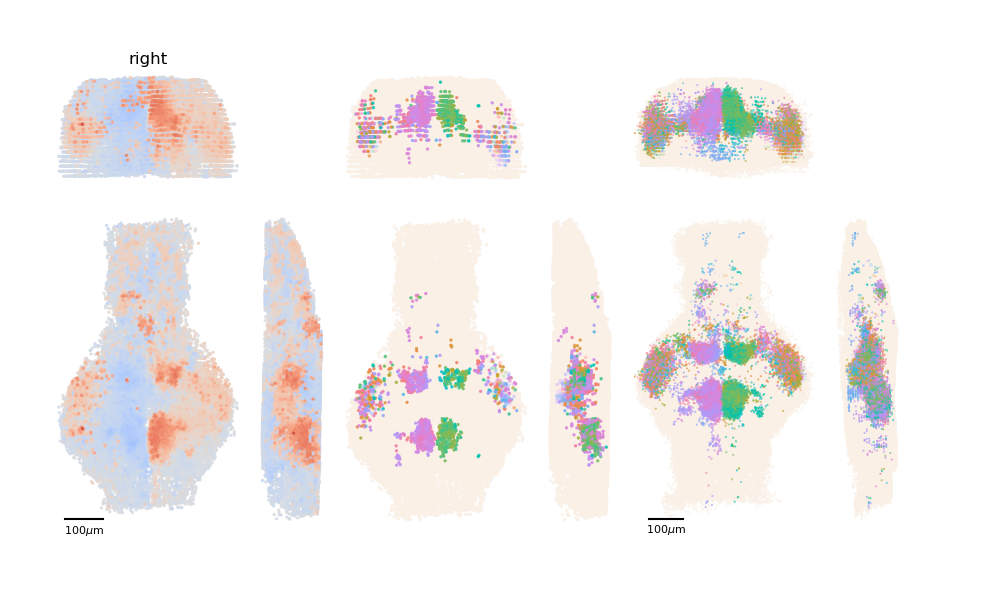

In [35]:
fig, axs = plt.subplots(2, 6, figsize=(10, 6), gridspec_kw={'width_ratios': [6, 2, 6, 2, 6, 2], 'height_ratios': [1, 3]})

fig.subplots_adjust(left=0.05, wspace=0.3, hspace=0.3)

#Regressors
axs[1,0].scatter(coords_ib[mp_ind_regressor,0], coords_ib[mp_ind_regressor,1], c=reg_corr_ib[mp_ind_regressor], s=dot_s, alpha=0.8, cmap='coolwarm', vmin=-1, vmax=1)
axs[1,1].scatter(coords_ib[mp_ind_regressor,2], coords_ib[mp_ind_regressor,1], c=reg_corr_ib[mp_ind_regressor], s=dot_s, alpha=0.8, cmap='coolwarm', vmin=-1, vmax=1)
axs[0,0].scatter(coords_ib[mp_ind_regressor,0], coords_ib[mp_ind_regressor,2], c=reg_corr_ib[mp_ind_regressor], s=dot_s, alpha=0.8, cmap='coolwarm', vmin=-1, vmax=1)
axs[0,0].set_title(titles[plot_dir])

#Tuning
axs[1,2].scatter(coords_ib[:,0], coords_ib[:,1], c='linen', s=dot_s, alpha=0.8)
axs[1,2].scatter(coords_vis[mp_ind_tuning,0], coords_vis[mp_ind_tuning,1], s=dot_s, c=colors_vis[mp_ind_tuning]/255, alpha=0.8)

axs[1,3].scatter(coords_ib[:,2], coords_ib[:,1], c='linen', s=dot_s, alpha=0.8)
axs[1,3].scatter(coords_vis[mp_ind_tuning,2], coords_vis[mp_ind_tuning,1], s=dot_s, c=colors_vis[mp_ind_tuning]/255, alpha=0.8)

axs[0,2].scatter(coords_ib[:,0], coords_ib[:,2], c='linen', s=dot_s, alpha=0.8)
axs[0,2].scatter(coords_vis[mp_ind_tuning,0], coords_vis[mp_ind_tuning,2], s=dot_s, c=colors_vis[mp_ind_tuning]/255, alpha=0.8)

#Pooled
axs[1,4].scatter(coords_ib_pooled[:,0], coords_ib_pooled[:,1], c='linen', s=dot_s/10, alpha=0.8)
axs[1,4].scatter(coords_vis_pooled[mp_ind_pooled,0], coords_vis_pooled[mp_ind_pooled,1], c=colors_vis_pooled[mp_ind_pooled]/255, s=dot_s/10, alpha=0.8)

axs[1,5].scatter(coords_ib_pooled[:,2], coords_ib_pooled[:,1], c='linen', s=dot_s/10, alpha=0.8)
axs[1,5].scatter(coords_vis_pooled[mp_ind_pooled,2], coords_vis_pooled[mp_ind_pooled,1], c=colors_vis_pooled[mp_ind_pooled]/255, s=dot_s/10, alpha=0.8)

axs[0,4].scatter(coords_ib_pooled[:,0], coords_ib_pooled[:,2], c='linen', s=dot_s/10, alpha=0.8)
axs[0,4].scatter(coords_vis_pooled[mp_ind_pooled,0], coords_vis_pooled[mp_ind_pooled,2], c=colors_vis_pooled[mp_ind_pooled]/255, s=dot_s/10, alpha=0.8)

#Scale bars
axs[1,0].plot((scale_bar_xpos, scale_bar_xpos+scale_bar_len), (scale_bar_ypos1, scale_bar_ypos1), c='black')
axs[1,0].text(scale_bar_xpos+(scale_bar_len/2), scale_bar_ypos1+10, r'{}$\mu$m'.format(scale_bar_len), va='top', ha='center', fontsize=fs)

axs[1,4].plot((scale_bar_xpos, scale_bar_xpos+scale_bar_len), (scale_bar_ypos2, scale_bar_ypos2), c='black')
axs[1,4].text(scale_bar_xpos+(scale_bar_len/2), scale_bar_ypos2+10, r'{}$\mu$m'.format(scale_bar_len), va='top', ha='center', fontsize=fs)

for ax in axs.flatten():
    ax.axis('off')
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)

# for ax in [axs[0,1], axs[0, 3], axs[0,5]]:
#     ax.axis('off')
    
for ax in [axs[1, 0], axs[1, 2], axs[1, 4]]:
    ax.invert_yaxis()
    
for ax in [axs[1, 1], axs[1, 3], axs[1, 5]]:
    ax.invert_yaxis()

plt.subplots_adjust(wspace=0.1, hspace=0.1)

In [36]:
axis_lims = [(l_lim, h_lim) for l_lim, h_lim in zip(np.min(coords_ib, 0), np.max(coords_ib, 0))]
axis_lims

[(83.61976, 552.37646), (84.30222, 618.48175), (61.273335, 312.8393)]

In [37]:
axis_sizes = [lim[1]-lim[0] for lim in axis_lims]
axis_sizes

[468.7567, 534.1795, 251.56596]

In [38]:
min_size = min(axis_sizes)
axis_ratios = [size/min_size for size in axis_sizes]
axis_ratios

[1.863355, 2.1234171, 1.0]

In [39]:
x = 0
y = 1
z = 2

In [40]:
#Import reference anatomy [from first fish]
ref_anatomy = fl.load(fish_list[0] / 'registration' / 'to_h2b_baier_ref' / 'antspy' / 'ref_mapped.h5')

In [45]:
ref_anatomy_cropped = ref_anatomy[50:550, 70:690, 50:]

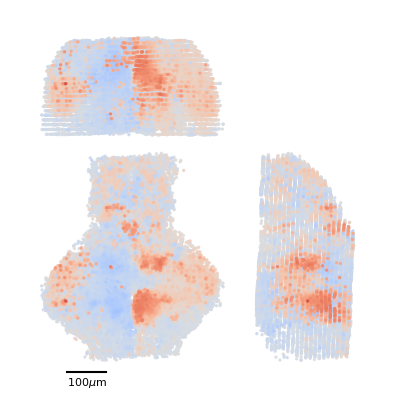

In [70]:
#Plot
y_main_rat = ref_anatomy_cropped.shape[1]/ref_anatomy_cropped.shape[0]
x_rat = ref_anatomy_cropped.shape[2]/ref_anatomy_cropped.shape[0]
y_rat = ref_anatomy_cropped.shape[2]/ref_anatomy_cropped.shape[1]*y_main_rat

fig = plt.figure(figsize=(4,4))
gs = fig.add_gridspec(2, 2, width_ratios=[1, x_rat], height_ratios=[y_rat, y_main_rat])

ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[0, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[1, 1], sharey=ax1)

mock_anatomy = np.zeros_like(ref_anatomy_cropped)
ax1.imshow(mock_anatomy.mean(2).T, cmap='gray_r')
ax2.imshow(mock_anatomy.mean(1).T, cmap='gray_r')
ax3.imshow(mock_anatomy.mean(0), cmap='gray_r')

ax1.scatter(coords_ib[mp_ind_regressor,0]-50, coords_ib[mp_ind_regressor,1]-50,
                 c=reg_corr_ib[mp_ind_regressor], s=dot_s, alpha=0.8, cmap='coolwarm', vmin=-1, vmax=1)
ax3.scatter(coords_ib[mp_ind_regressor,2]-50, coords_ib[mp_ind_regressor,1]-50, 
                 c=reg_corr_ib[mp_ind_regressor], s=dot_s, alpha=0.8, cmap='coolwarm', vmin=-1, vmax=1)
ax2.scatter(coords_ib[mp_ind_regressor,0]-50, coords_ib[mp_ind_regressor,2]-50, 
                 c=reg_corr_ib[mp_ind_regressor], s=dot_s, alpha=0.8, cmap='coolwarm', vmin=-1, vmax=1)
#ax2.set_title(titles[plot_dir])

#Scale bars
scale_bar_ypos1 = 600
ax1.plot((scale_bar_xpos, scale_bar_xpos+scale_bar_len), (scale_bar_ypos1, scale_bar_ypos1), c='black')
ax1.text(scale_bar_xpos+(scale_bar_len/2), scale_bar_ypos1+10, r'{}$\mu$m'.format(scale_bar_len), va='top', ha='center', fontsize=fs)


ax3.invert_yaxis()
# ax1.invert_yaxis()
# for ax in [ax1, ax2, ax3]:
#     ax.axis('off')

plt.subplots_adjust(hspace=0.001, wspace=0.01, left=0.05, right=0.95, top=0.95, bottom=0.05)
ax1.invert_yaxis()
ax2.invert_yaxis()

for ax in [ax1, ax2, ax3]:
     ax.axis('off')

In [61]:
fig.savefig(master / 'corr_panel_test.jpg', dpi=300)

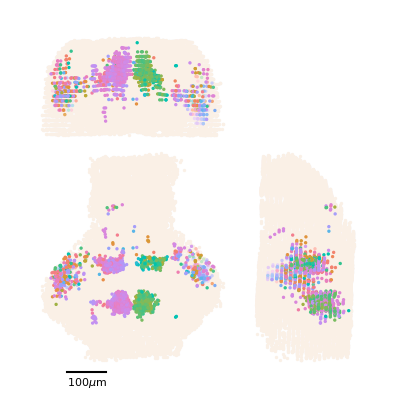

In [62]:
#Plot
#y_main_rat = ref_anatomy_cropped.shape[1]/ref_anatomy_cropped.shape[0]
#x_rat = ref_anatomy_cropped.shape[2]/ref_anatomy_cropped.shape[0]
#y_rat = ref_anatomy_cropped.shape[2]/ref_anatomy_cropped.shape[1]*y_main_rat

fig_tun = plt.figure(figsize=(4,4))
gs = fig_tun.add_gridspec(2, 2, width_ratios=[1, x_rat], height_ratios=[y_rat, y_main_rat])

ax_tun1 = fig_tun.add_subplot(gs[1, 0])
ax_tun2 = fig_tun.add_subplot(gs[0, 0], sharex=ax_tun1)
ax_tun3 = fig_tun.add_subplot(gs[1, 1], sharey=ax_tun1)

mock_anatomy = np.zeros_like(ref_anatomy_cropped)
ax_tun1.imshow(mock_anatomy.mean(2).T, cmap='gray_r')
ax_tun2.imshow(mock_anatomy.mean(1).T, cmap='gray_r')
ax_tun3.imshow(mock_anatomy.mean(0), cmap='gray_r')

ax_tun1.scatter(coords_ib[:,0]-50, coords_ib[:,1]-50, s=dot_s, alpha=1, c='linen')
ax_tun1.scatter(coords_vis[mp_ind_tuning,0]-50, coords_vis[mp_ind_tuning,1]-50, c=colors_vis[mp_ind_tuning]/255, s=dot_s/1, alpha=1)

ax_tun3.scatter(coords_ib[:,2]-50, coords_ib[:,1]-50, s=dot_s, alpha=1, c='linen')
ax_tun3.scatter(coords_vis[mp_ind_tuning,2]-50, coords_vis[mp_ind_tuning,1]-50, c=colors_vis[mp_ind_tuning]/255, s=dot_s/1, alpha=1)

ax_tun2.scatter(coords_ib[:,0]-50, coords_ib[:,2]-50, s=dot_s, alpha=1, c='linen')
ax_tun2.scatter(coords_vis[mp_ind_tuning,0]-50, coords_vis[mp_ind_tuning,2]-50, c=colors_vis[mp_ind_tuning]/255, s=dot_s/1, alpha=1)

#Scale bars
scale_bar_ypos1 = 600
ax_tun1.plot((scale_bar_xpos, scale_bar_xpos+scale_bar_len), (scale_bar_ypos1, scale_bar_ypos1), c='black')
ax_tun1.text(scale_bar_xpos+(scale_bar_len/2), scale_bar_ypos1+10, r'{}$\mu$m'.format(scale_bar_len), va='top', ha='center', fontsize=fs)


#ax_tun3.invert_yaxis()
#ax_tun1.invert_yaxis()
ax_tun2.invert_yaxis()


for ax in [ax_tun1, ax_tun2, ax_tun3]:
     ax.axis('off')
        
plt.subplots_adjust(hspace=0.001, wspace=0.01, left=0.05, right=0.95, top=0.95, bottom=0.05)

In [64]:
ax_tun3.invert_yaxis()
ax_tun1.invert_yaxis()
#ax_tun2.invert_yaxis()

In [65]:
fig_tun.savefig(master / 'tuning_5pct_panel_test.jpg', dpi=300)

In [66]:
coords_vis_pooled = coords_ib_pooled[selected_vis]
colors_vis_pooled = colors_ib[selected_vis]
amp_vis = amp_pooled_ib[selected_vis]

mp_ind_pooled = np.argsort(amp_vis)

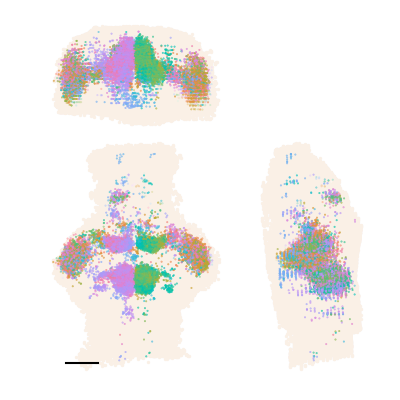

In [67]:
#Plot
y_main_rat = ref_anatomy_cropped.shape[1]/ref_anatomy_cropped.shape[0]
x_rat = ref_anatomy_cropped.shape[2]/ref_anatomy_cropped.shape[0]
y_rat = ref_anatomy_cropped.shape[2]/ref_anatomy_cropped.shape[1]*y_main_rat

fig_pool = plt.figure(figsize=(4,4))
gs = fig_pool.add_gridspec(2, 2, width_ratios=[1, x_rat], height_ratios=[y_rat, y_main_rat])

ax_pool1 = fig_pool.add_subplot(gs[1, 0])
ax_pool2 = fig_pool.add_subplot(gs[0, 0], sharex=ax_pool1)
ax_pool3 = fig_pool.add_subplot(gs[1, 1], sharey=ax_pool1)

mock_anatomy = np.zeros_like(ref_anatomy_cropped)
ax_pool1.imshow(mock_anatomy.mean(2).T, cmap='gray_r')
ax_pool2.imshow(mock_anatomy.mean(1).T, cmap='gray_r')
ax_pool3.imshow(mock_anatomy.mean(0), cmap='gray_r')

ax_pool1.scatter(coords_ib_pooled[:,0], coords_ib_pooled[:,1]-50, s=dot_s, alpha=1, c='linen')
ax_pool1.scatter(coords_vis_pooled[mp_ind_pooled,0], coords_vis_pooled[mp_ind_pooled,1]-50, c=colors_vis_pooled[mp_ind_pooled]/255, s=dot_s/10, alpha=0.8)

ax_pool3.scatter(coords_ib_pooled[:,2], coords_ib_pooled[:,1]-50, s=dot_s, alpha=1, c='linen')
ax_pool3.scatter(coords_vis_pooled[mp_ind_pooled,2], coords_vis_pooled[mp_ind_pooled,1]-50, c=colors_vis_pooled[mp_ind_pooled]/255, s=dot_s/10, alpha=0.8)

ax_pool2.scatter(coords_ib_pooled[:,0], coords_ib_pooled[:,2]+30, s=dot_s, alpha=1, c='linen')
ax_pool2.scatter(coords_vis_pooled[mp_ind_pooled,0], coords_vis_pooled[mp_ind_pooled,2]+30, c=colors_vis_pooled[mp_ind_pooled]/255, s=dot_s/10, alpha=0.8)

#Scale bars
scale_bar_ypos1 = 700
ax_pool1.plot((scale_bar_xpos, scale_bar_xpos+scale_bar_len), (scale_bar_ypos1, scale_bar_ypos1), c='black')
#ax_pool1.text(scale_bar_xpos+(scale_bar_len/2), scale_bar_ypos1+10, r'{}$\mu$m'.format(scale_bar_len), va='top', ha='center', fontsize=fs)


#ax_pool3.invert_yaxis()
#ax_pool1.invert_yaxis()
ax_pool2.invert_yaxis()


for ax in [ax_pool1, ax_pool2, ax_pool3]:
     ax.axis('off')
        
plt.subplots_adjust(hspace=0.01, wspace=0.00, left=0.05, right=0.95, top=0.95, bottom=0.05)

In [68]:
fig_pool.savefig(master / 'pooled tuning_5pct_panel_test.jpg', dpi=300)